University of Helsinki, Department of Mathematics and Statistics  
MAST32001 Computational Statistics I, Spring 2018  
Antti Honkela  

# Week 2 exercises

## 1. Permutation testing

We will use permutation testing to study if the mother's age (age, below or at least 26) affects the birth weight (bwt) of their babies. We will use the absolute difference in the means as the test statistic. We will focus the analysis on full term pregnancies (gestation >= 273).

Note: when reporting a $p$-value for $b$ more extreme tests out of $m$, use $p = (b+1)/(m+1)$ to avoid zero p-values. 50000 permutations will be sufficient for obtaining the required accuracy.

1. Load the data set below. Test whether the birth weights (bwt) of babies with young (age < 26) and older (age >= 26) mothers are statistically significantly different using the difference of the means as the test statistic. Report the $p$-value you obtain in Moodle.
2. Stratify the analysis by the variable smoking status of the mothers by splitting to separate smoker and non-smoker groups. Constrain the permutations so that only changes within each group are allowed. After the permutation merge the two groups back together to compute the means. Report the $p$-value you obtain in Moodle.

In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import scipy.stats as sst

npr.seed(1345)
# Load the data set
babies_full = pd.read_csv("http://www.helsinki.fi/~ahonkela/teaching/compstats1/babies.txt", sep='\t')

# Pick a subset
babies1 = babies_full.iloc[(babies_full['gestation']>=273).values]
babiesYoung = babies1.query('age<26')
babiesOld = babies1.query('age>=26')

smoker = babies1.query('smoke>0')
nonSmoker = babies1.query('smoke<1')

#print(babies1.head(10))

X1 = babiesYoung['bwt'].mean()
X2 = babiesOld['bwt'].mean()
t = np.abs(X1-X2)
s1 = np.var(babiesYoung['bwt'])
s2 = np.var(babiesOld['bwt'])
N1 = len(babiesYoung.index)
N2 = len(babiesOld.index)

def sTest(X1,X2,s1,s2,N1,N2):
    return (X1-X2)/np.sqrt((s1/N1)+(s2/N2))

tX, pX = sst.ttest_ind(babiesYoung['bwt'], babiesOld['bwt'], equal_var=False)
tXf = sTest(X1,X2,s1,s2,N1,N2)
print('pFunktio ', pX)
print('t oma ', tXf)
df = N1+N2 -2
pXf = sst.t.cdf(tXf,df=df)
t_val = sst.t.ppf([pXf], df)
print('t_val ', t_val)
print('pXf ', pXf)

# oldSmoker = babiesOld.query('smoke=1')
# oldNonsmoker = babiesOld.query('smoke=0')
# youngSmoker = babiesYoung.query('smoke=1')
# youngNonsmoker = babiesYoung.query('smoke=0')

N_perm = 50000


truediff_smoke = np.abs(smoker['bwt'].mean() - nonSmoker['bwt'].mean())

print('smoker mean ', truediff_smoke)

meandiffs = np.zeros(N_perm)
for i in range(N_perm):
    z = smoker.sample(n=20)
    #print(z['bwt'])
    zz =  nonSmoker.sample(n=20)
    meandiffs[i] = np.abs(z['bwt'].mean() - zz['bwt'].mean())

#print(meandiffs)
print('p-value:', (np.sum(truediff_smoke <= meandiffs)+1)/(len(meandiffs)+1))

    bwt  gestation  parity  age  height  weight  smoke
0   120        284       0   27      62     100      0
1   113        282       0   33      64     135      0
2   128        279       0   28      64     115      1
3   108        282       0   23      67     125      1
4   136        286       0   25      62      93      0
7   120        289       0   25      62     125      0
8   143        299       0   30      66     136      1
9   140        351       0   27      68     120      0
10  144        282       0   32      64     124      1
11  141        279       0   23      63     128      1
pFunktio  0.052685000646563666
t oma  -1.9423661130819316
t_val  [-1.94236611]
pXf  0.026206489250117225
smoker mean  7.040909090909096
p-value: 0.5066098678026439


## 2. Bootstrap confidence intervals on data statistics

In this exercise we use bootstrap to estimate confidence intervals for various quantities. (Using 1000 bootstrap samples will give you enough accuracy assuming everything is correctly done.)

1. Use bootstrap to estimate the central 95% confidence interval for the mean of 'bwt' in the full data set loaded in Problem 1. Report the width of the interval in Moodle.
2. Use bootstrap to estimate the central 95% confidence interval for the mean of 'bwt' in the smaller subset of the data set used in Problem 1. Report the width of the interval in Moodle.
3. Use bootstrap to estimate the central 95% confidence interval for the correlation coefficient of 'gestation' and 'age' in the full data set loaded in Problem 1. What does this tell about the relation between the duration of the pregnancy and the age of the mother? Report the bounds of the interval in Moodle.
4. Use bootstrap to estimate the central 95% confidence interval for the correlation coefficient of 'gestation' and 'age' in the smaller subset used in Problem 1. What does this tell about the relation between the duration of the pregnancy and the age of the mother? Report the bounds of the interval in Moodle.

Hint: remember that the size of the bootstrap sample is always the same as the size of the original data set.

In [4]:
import numpy as np
import numpy.random as npr
import pandas as pd
import scipy.stats as sst

npr.seed(1345)
# Load the data set
babies_full = pd.read_csv("http://www.helsinki.fi/~ahonkela/teaching/compstats1/babies.txt", sep='\t')

bwt = babies_full['bwt']

N = 1000
N_bwt = len(bwt)

def bootstrapMeans(data, n):
    bootstrap_means = np.array([np.mean(npr.choice(data, replace=True, size=n)) for i in range(N)])
    print('bootstrap interval:', np.percentile(bootstrap_means, [2.5, 97.5]))
    ival1, ival2 = np.percentile(bootstrap_means, [2.5, 97.5])
    ival_width = abs(ival1-ival2)
    print('interval width: ', ival_width)

bootstrapMeans(bwt, N_bwt)

bootstrap_means = np.array([np.mean(npr.choice(bwt, replace=True, size=N_bwt)) for i in range(N)])
print('1. bootstrap interval:', np.percentile(bootstrap_means, [2.5, 97.5]))
ival1, ival2 = np.percentile(bootstrap_means, [2.5, 97.5])
ival_width = abs(ival1-ival2)
print('interval width: ', ival_width)

babies1 = babies_full.iloc[(babies_full['gestation']>=273).values]
bwt1 = babies1['bwt']
N_bwt1 = len(bwt1)

bootstrapMeans(bwt1, N_bwt1)

bootstrap_means1 = np.array([np.mean(npr.choice(bwt1, replace=True, size=N_bwt1)) for i in range(N)])
print('2. bootstrap interval:', np.percentile(bootstrap_means1, [2.5, 97.5]))
ival1, ival2 = np.percentile(bootstrap_means1, [2.5, 97.5])
ival_width = abs(ival1-ival2)
print('interval width: ', ival_width)

gestation = babies_full['gestation']
age = babies_full['age']
N_gestation = len(gestation)
correlation_interval = np.zeros(N)
for i in range(N):
    indices = npr.choice(range(N_gestation), replace=True, size=N_gestation)
    correlation_interval[i] = np.corrcoef(gestation.values[indices], age.values[indices])[0,1]

print('3. bootstrap interval:', np.percentile(correlation_interval, [2.5, 97.5]))
ival1, ival2 = np.percentile(correlation_interval, [2.5, 97.5])
ival_width = abs(ival1-ival2)
print('interval width: ', ival_width)

gestation = babies1['gestation']
age = babies1['age']
N_gestation = len(gestation)
correlation_interval = np.zeros(N)
for i in range(N):
    indices = npr.choice(range(N_gestation), replace=True, size=N_gestation)
    correlation_interval[i] = np.corrcoef(gestation.values[indices], age.values[indices])[0,1]

print('4. bootstrap interval:', np.percentile(correlation_interval, [2.5, 97.5]))
ival1, ival2 = np.percentile(correlation_interval, [2.5, 97.5])
ival_width = abs(ival1-ival2)
print('interval width: ', ival_width)

bootstrap interval: [118.57123838 120.62554945]
interval width:  2.0543110735418537
1. bootstrap interval: [118.5433432 120.6239011]
interval width:  2.0805579036348263
bootstrap interval: [122.57958428 124.67104214]
interval width:  2.091457858769914
2. bootstrap interval: [122.59083144 124.63442483]
interval width:  2.0435933940774618
3. bootstrap interval: [-0.10796613  0.00499416]
interval width:  0.11296029758576719
4. bootstrap interval: [-0.09303774  0.03640723]
interval width:  0.12944496924853782


## 3. Bootstrap confidence intervals on parameter estimates

In this task, we will use bootstrap to obtain confidence intervals on maximum likelihood parameter estimates for linear regression models. We will apply simple case resampling, i.e. resampling the individuals and then fitting the model using the data $(x_i, y_i)$ from these individuals. There are alternative methods that may work better when the data are limited, but in our case there are enough observations so that this will not be a problem. 1000 bootstrap samples will again give you enough accuracy.

Linear regression fit to scalar $x_i, y_i$ involves fitting the model
$$ y_i = \alpha + \beta x_i + \epsilon_i, $$
where $\beta$ is the regression coefficient and $\alpha$ is the intercept. Assuming $\epsilon_i \sim N(0, \sigma^2)$, the log-likelihood of the model is
$$ \log p(Y | X, \alpha, \beta) = \sum_{i=1}^n \log p(y_i | x_i, \alpha, \beta)
  = \sum_{i=1}^n - \frac{1}{2 \sigma^2} (y_i - \alpha - \beta x_i)^2 + C, $$
where $C$ is independent of $\alpha, \beta$. This is maximised when
$$ \hat{\beta}= \frac{\sum_{i = 1}^n (x - \bar{x})(y - \bar{y}) }{ \sum_{i = 1}^n (x - \bar{x})^2} \\
   \hat{\alpha} = \bar{y} - \hat{\beta} \bar{x},$$
where $\bar{x} = \frac{1}{n} \sum_{i = 1}^n x$ and $\bar{y} = \frac{1}{n} \sum_{i = 1}^n y$.

1. Implement the above linear regression model to predict 'gestation' ($y$) as a function of 'age' ($x$) in the full data set. Report the estimated $\beta$ in Moodle.
2. Use bootstrap to estimate the confidence interval of the regression coefficient $\beta$ in the above model by resampling the individuals used to fit the model. Report the lower and upper bounds of the central 95% confidence interval of $\beta$ in Moodle.


In [ ]:
#%%
import numpy as np
import numpy.random as npr
import pandas as pd
import scipy.stats as sst
import matplotlib.pyplot as plt

npr.seed(1345)
# Load the data set
babies_full = pd.read_csv("http://www.helsinki.fi/~ahonkela/teaching/compstats1/babies.txt", sep='\t')

N=1000

y = babies_full['gestation'].values
x = babies_full['age'].values
var = 1
epsilon = npr.normal(0,var)

def loglh(x,y,n,a,b,C,var):
    res = 0
    for i in range(n):
        res = res + (-(1/2*var)*(y[i]-a-b*x[i])**2 + C)
    return res

def b_hat(x,y,a):
    xmean = np.mean(x)
    ymean = np.mean(y)
    x2 = x-xmean
    y2 = y-ymean
    return (x2*y2)/(x2**2) * a

plt.scatter(x,y)
plt.plot(x,y)
plt.show()

print(b_hat(x,y,1))

## 4. Density estimation

1. Estimate the joint density of 'bwt' and 'age' in the full data set using kernel density estimation with a 2-dimensional Gaussian kernel
$$ K_h(x) = \frac{1}{2\pi h^2} \exp\left( - \frac{x_1^2 + x_2^2}{2 h^2} \right) $$
with $h=5$. Plot a 2D histogram of the data (`matplotlib.pyplot.hist2d`) and a contour plot of the estimated density. Report the value of the estimated density at point bwt=120, age=25 in Moodle.
2. Use leave-one-out cross validation to find an optimal $h$ in the range `np.linspace(1.0, 10.0, 30)`. Report the value of $h$ and the value of the estimated density at bwt=120, age=25 in Moodle.

1183 7.74192859066709e-40


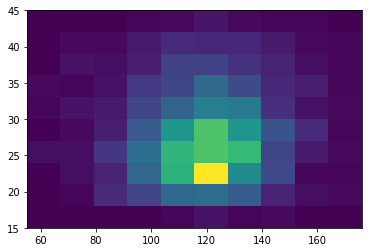

bwt 120 age 25  1.9878715171199938e-133


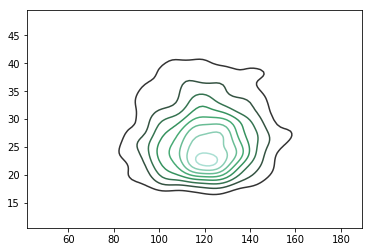

In [24]:
#%%
import numpy as np
import numpy.random as npr
import pandas as pd
import scipy.stats as sst
import matplotlib.pyplot as plt
import seaborn as sns

npr.seed(1345)
# Load the data set
babies_full = pd.read_csv("http://www.helsinki.fi/~ahonkela/teaching/compstats1/babies.txt", sep='\t')
bwt = babies_full['bwt'].values
age = babies_full['age'].values

def Kh(x1,x2):
    first = 1/(2*np.pi*h**2)
    second = np.exp(-(x1**2 + x2**2)/(2*h**2))
    return first*second

matrix = np.column_stack((bwt, age))
h=5
t = np.linspace(0.0,200.0,num=len(bwt))
#plt.hist2d(bwt,age)
Kres = Kh(age,bwt)
matrix = np.column_stack((bwt, age, Kres))
print(len(Kres), np.max(Kres))
#print(Kres)
plt.hist2d(bwt,age)
plt.show()
print('bwt 120 age 25 ', Kh(25,120))
sns.kdeplot(bwt, age, kernel='gau')

## 5. Cross validation for variable selection in linear regression

Cross validation can be used for evaluating the out-of-sample predictive accuracy of models and feature selection. In this task we will study a subset of the birth weight data for old mothers ($\text{age} \ge 30$) and aim to predict the birth weight ('bwt', $y$) as a function of the duration of the pregnancy ('gestation', $x$). We will then evaluate the root mean squared error (RMSE)
$$ RMSE(\epsilon) = \sqrt{\frac{1}{n} \sum_{i=1}^n \epsilon_i^2} $$
of the model.

1. Use all data to fit the linear regression model and evaluate the RMSE of all the predictions. Report the value you obtain in Moodle.
2. Use $k$-fold cross-validation with $k=20$ and estimate the RMSE of the test set predictions. Report the value you obtain in Moodle.
3. Fit a multivariate linear regression model using 'age', 'gestation' and 'weight' as predictors. Report the value of the regression coefficient of 'weight' in Moodle.
4. Evaluate the RMSE of the multivariate fit using LOO CV. Report the value you obtain in Moodle.

Hint: Subtasks 1 and 2 use the linear regression model also used in Problem 3 while subtasks 3 and 4 use a multivariate version of linear regression. To form the multivariate linear regression model, let us consider the data as a matrix $\mathbf{X}$ where each row is an observation and each column is a variable, and $\mathbf{y}$ as a column vector of responses. We can incorporate the intercept $\alpha$ in the same parameter vector $\boldsymbol{\beta}$ by
$$ \mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \alpha \mathbf{1} = \begin{pmatrix} \mathbf{X} & \mathbf{1} \end{pmatrix}
\begin{pmatrix} \boldsymbol{\beta} \\ \alpha \end{pmatrix} = \mathbf{X'} \boldsymbol{\beta'}, $$
i.e. by adding a column of all ones to the data matrix $\mathbf{X}$. In what follows, we will use $\mathbf{X}$ to denote the augmented data matrix and $\boldsymbol{\beta}$ to denote the corresponding augmented vector of regression coefficients.

The maximum likelihood estimate of $\boldsymbol{\beta}$ for the multivariate model can be derived in a similar manner as in Problem 3. The result is
$$ \hat{\boldsymbol{\beta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}. $$

In [ ]:
import pandas as pd
import numpy as np
import numpy.random as npr

# Load the data set
babies_full = pd.read_csv("http://www.helsinki.fi/~ahonkela/teaching/compstats1/babies.txt", sep='\t')

# Pick a subset
babies5 = babies_full.loc[(babies_full['age']>=30).values,:]
